## advice from krish:
- Forward selection after interaction terms
- Use bins as predictors - not quadratic 

- Conceptual: Slide 5: Visualization must be before stepwise selection. A variable requiring transformation / binning to significantly explain the response may get dropped in stepwise. Stepwise selection should be done after considering interactions. 
- Slide 9: Plug-in the bins of TrainingTimesLastYear as predictors. For DistanceFromHome, it seems like no binning / transformation is needed as it almost has a monotonic relationship with the response. For the report; If not already, obtain the final model using some variable selection approach - maybe some predictor will drop - making it easier to infer, without compromising prediction accuracy. As you have enough predictors, try to come up with at least some non-intuitive recommendations, and quantify the impact of recommendations

In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
import statsmodels.formula.api as sm
import warnings 
import itertools
import time

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 8,5

In [3]:
warnings.filterwarnings('ignore')

In [4]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

# Description of Variables

- Age: The age of the employee. (Numerical)
- Attrition: Whether or not the employee has left the organization. (Categorical)
- BusinessTravel: The frequency of business travel for the employee. (Categorical)
- DailyRate: The daily rate of pay for the employee. (Numerical)
- Department: The department the employee works in. (Categorical)
- DistanceFromHome: The distance from home in miles for the employee. (Numerical)
- Education: The level of education achieved by the employee. (Categorical)
- EducationField: The field of study for the employee's education. (Categorical)
- EmployeeCount: The total number of employees in the organization. (Numerical)
- EmployeeNumber: A unique identifier for each employee profile. (Numerical)
- EnvironmentSatisfaction: The employee's satisfaction with their work environment. (Categorical)
- Gender: The gender of the employee. (Categorical)
- HourlyRate: The hourly rate of pay for the employee. (Numerical)
- JobInvolvement: The level of involvement required for the employee's job. (Categorical)
- JobLevel: The job level of the employee. (Categorical)
- JobRole: The role of the employee in the organization. (Categorical)
- JobSatisfaction: The employee's satisfaction with their job. (Categorical)
- MaritalStatus: The marital status of the employee. (Categorical)
- MonthlyIncome: The monthly income of the employee. (Numerical)
- MonthlyRate: The monthly rate of pay for the employee. (Numerical)
- NumCompaniesWorked: The number of companies the employee has worked for. (Numerical)
- Over18: Whether or not the employee is over 18. (Categorical)
- OverTime: Whether or not the employee works overtime. (Categorical)
- PercentSalaryHike: The percentage of salary hike for the employee. (Numerical)
- PerformanceRating: The performance rating of the employee. (Categorical)
- RelationshipSatisfaction: The employee's satisfaction with their relationships. (Categorical)
- StandardHours: The standard hours of work for the employee. (Numerical)
- StockOptionLevel: The stock option level of the employee. (Numerical)
- TotalWorkingYears: The total number of years the employee has worked. (Numerical)
- TrainingTimesLastYear: The number of times the employee was taken for training in the last year. (Numerical)
- WorkLifeBalance: The employee's perception of their work-life balance. (Categorical)
- YearsAtCompany: The number of years the employee has been with the company. (Numerical)
- YearsInCurrentRole: The number of years the employee has been in their current role. (Numerical)
- YearsSinceLastPromotion: The number of years since the employee's last promotion. (Numerical)
- YearsWithCurrManager: The number of years the employee has been with their current manager. (Numerical)

- make people who leave the job 1 (bc there are far less of them)
- min false neg rate to maximizew recall 
- precision recall is a good metric to optimize (most imp recall)
- minimize ppl who will leave

In [5]:
#Load data
df=pd.read_csv("data/HR_Analytics.csv")
df = pd.get_dummies(df, columns = ["Attrition"])
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_No,Attrition_Yes
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,...,0,8,0,1,6,4,0,5,0,1
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,...,1,10,3,3,10,7,1,7,1,0
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,...,0,7,3,3,0,0,0,0,0,1
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,...,0,8,3,3,8,7,3,0,1,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,...,1,6,3,3,2,2,2,2,1,0


In [6]:
#Keep the dummy column where employees leaving = 1, because there are far less of them and we want to minimize FNR and recall
df = df.drop(["Attrition_No"], axis = 1)

In [7]:
#Splitting up data into train and test data - train has 70% of values and test has 30%
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=25)

print(f"No. of training examples: {train.shape[0]}")
print(f"No. of testing examples: {test.shape[0]}")


No. of training examples: 1029
No. of testing examples: 441


In [8]:
#Printing the ratio of No's and Yes's to the response variable (Attrition) for train and test to make sure they are similar
print(train.Attrition_Yes.value_counts()[1]/train.Attrition_Yes.value_counts()[0])
print(test.Attrition_Yes.value_counts()[1]/test.Attrition_Yes.value_counts()[0])

0.1937354988399072
0.18867924528301888


In [9]:
#There are zero missing values that need to be filled in either data set
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


In [10]:
#Drop employee count, over 18 and standard hours because they are the same value for every person
train = train.drop(["EmployeeCount", "StandardHours", "Over18"], axis = 1)
test = test.drop(["EmployeeCount", "StandardHours", "Over18"], axis = 1)
train.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition_Yes'],
      dtype='object')

In [11]:
df = df.drop(columns = ['Over18','StandardHours','EmployeeCount'])
# We should just drop these columns because they only have 1 unique values and contain no information

<AxesSubplot:>

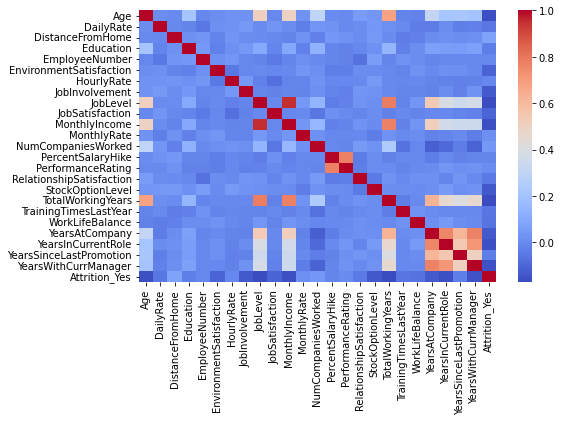

In [12]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')

In [13]:
# separate the target variable and predictor variables
X = df.drop(columns = ['Attrition_Yes'], axis=1)
y = df['Attrition_Yes']

In [14]:
X = X.rename(columns=lambda x: x.strip())

X = pd.get_dummies(X, drop_first = True)
X.columns = X.columns.str.replace('-', '')
X.columns = X.columns.str.replace(' ', '')
X.columns = X.columns.str.replace('&', '_')

X

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,1,2,94,3,2,4,...,0,0,0,0,0,1,0,0,1,1
1,49,279,8,1,2,3,61,2,2,2,...,0,0,0,0,1,0,0,1,0,0
2,37,1373,2,2,4,4,92,2,1,3,...,1,0,0,0,0,0,0,0,1,1
3,33,1392,3,4,5,4,56,3,1,3,...,0,0,0,0,1,0,0,1,0,1
4,27,591,2,1,7,1,40,3,1,2,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,2061,3,41,4,2,4,...,1,0,0,0,0,0,0,1,0,0
1466,39,613,6,1,2062,4,42,2,3,1,...,0,0,0,0,0,0,0,1,0,0
1467,27,155,4,3,2064,2,87,4,2,2,...,0,0,1,0,0,0,0,1,0,1
1468,49,1023,2,3,2065,4,63,2,2,2,...,0,0,0,0,0,1,0,1,0,0


In [15]:
test = test.rename(columns=lambda x: x.strip())

test = pd.get_dummies(test, drop_first = True)
test.columns = test.columns.str.replace('-', '')
test.columns = test.columns.str.replace(' ', '')
test.columns = test.columns.str.replace('&', '_')

test = pd.get_dummies(test, drop_first = True)
test.shape
test

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
942,36,325,10,4,1312,4,63,3,3,3,...,0,0,0,0,0,0,0,1,0,0
415,34,296,6,2,555,4,33,1,1,3,...,0,0,0,0,0,0,1,0,0,0
1259,30,305,16,3,1763,3,58,4,2,3,...,0,0,0,0,0,0,0,1,0,0
466,41,1276,2,5,625,2,91,3,4,1,...,0,1,0,0,0,0,0,1,0,0
424,57,210,29,3,568,1,56,2,4,4,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,42,933,19,3,752,3,57,4,1,3,...,0,0,0,0,1,0,0,0,0,1
1292,39,766,20,3,1812,3,83,3,2,4,...,0,0,0,0,0,1,0,0,0,0
1186,35,880,12,4,1667,4,36,3,2,4,...,0,0,0,0,0,1,0,0,1,1
37,35,890,2,3,49,4,97,3,1,4,...,0,0,0,0,0,0,1,1,0,0


In [16]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# perform oversampling on the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# print the number of examples in each class before and after oversampling
print("Before oversampling:")
print(y_train.value_counts())
print("After oversampling:")
print(y_train_resampled.value_counts())

Before oversampling:
0    978
1    198
Name: Attrition_Yes, dtype: int64
After oversampling:
0    978
1    978
Name: Attrition_Yes, dtype: int64


In [17]:
y_train_resampled.name = 'Attrition_Yes'

# Checking VIF, dropping variables with VIF>10 1-by-1

In [ ]:
calculate_vif_(X_train_resampled, thresh=10.0)

In [18]:
# check for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  596.631312
1                                Age    2.193194
2                          DailyRate    1.079127
3                   DistanceFromHome    1.085088
4                          Education    1.131678
5                     EmployeeNumber    1.067639
6            EnvironmentSatisfaction    1.067232
7                         HourlyRate    1.053239
8                     JobInvolvement    1.065647
9                           JobLevel   15.426832
10                   JobSatisfaction    1.072875
11                     MonthlyIncome   18.192908
12                       MonthlyRate    1.096248
13                NumCompaniesWorked    1.339920
14                 PercentSalaryHike    2.590110
15                 PerformanceRating    2.566481
16          RelationshipSatisfaction    1.060952
17                  StockOptionLevel    1.984369
18                 TotalWorkingYears    5.441899
19             Train

In [19]:
# Drop the feature with the greatest VIF (Department_Research_Development)
col_to_drop = ["Department_Research_Development"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [20]:
#Retesting VIF without Department_Research_Development
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  354.460687
1                                Age    2.193194
2                          DailyRate    1.079122
3                   DistanceFromHome    1.083467
4                          Education    1.130747
5                     EmployeeNumber    1.067608
6            EnvironmentSatisfaction    1.066861
7                         HourlyRate    1.053187
8                     JobInvolvement    1.064846
9                           JobLevel   15.418660
10                   JobSatisfaction    1.072872
11                     MonthlyIncome   18.184693
12                       MonthlyRate    1.094678
13                NumCompaniesWorked    1.337916
14                 PercentSalaryHike    2.588563
15                 PerformanceRating    2.566358
16          RelationshipSatisfaction    1.059649
17                  StockOptionLevel    1.984009
18                 TotalWorkingYears    5.423582
19             Train

In [21]:
# Drop the feature with the greatest VIF (Department_Sales)
col_to_drop = ["Department_Sales"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [22]:
#Retesting VIF without Department_Sales
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  354.426165
1                                Age    2.192868
2                          DailyRate    1.078610
3                   DistanceFromHome    1.083052
4                          Education    1.130226
5                     EmployeeNumber    1.067222
6            EnvironmentSatisfaction    1.064463
7                         HourlyRate    1.053035
8                     JobInvolvement    1.061979
9                           JobLevel   15.413640
10                   JobSatisfaction    1.072613
11                     MonthlyIncome   18.153276
12                       MonthlyRate    1.094675
13                NumCompaniesWorked    1.337682
14                 PercentSalaryHike    2.580733
15                 PerformanceRating    2.563686
16          RelationshipSatisfaction    1.059632
17                  StockOptionLevel    1.983423
18                 TotalWorkingYears    5.423571
19             Train

In [23]:
# Drop the feature with the greatest VIF (EducationField_LifeSciences)
col_to_drop = ["EducationField_LifeSciences"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [24]:
#Retesting VIF without EducationField_LifeSciences
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  275.768048
1                                Age    2.192837
2                          DailyRate    1.077953
3                   DistanceFromHome    1.082457
4                          Education    1.128636
5                     EmployeeNumber    1.066762
6            EnvironmentSatisfaction    1.063689
7                         HourlyRate    1.051971
8                     JobInvolvement    1.061926
9                           JobLevel   15.412618
10                   JobSatisfaction    1.072306
11                     MonthlyIncome   18.152727
12                       MonthlyRate    1.092353
13                NumCompaniesWorked    1.335664
14                 PercentSalaryHike    2.580235
15                 PerformanceRating    2.563067
16          RelationshipSatisfaction    1.059580
17                  StockOptionLevel    1.982964
18                 TotalWorkingYears    5.421276
19             Train

In [25]:
# Drop the feature with the greatest VIF (MonthlyIncome)
col_to_drop = ["MonthlyIncome"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [26]:
#Retesting VIF without MonthlyIncome
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns
col_to_drop = ["JobLevel"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)


                             feature         VIF
0                              const  275.492166
1                                Age    2.191315
2                          DailyRate    1.073006
3                   DistanceFromHome    1.080057
4                          Education    1.128636
5                     EmployeeNumber    1.065420
6            EnvironmentSatisfaction    1.060994
7                         HourlyRate    1.051374
8                     JobInvolvement    1.056253
9                           JobLevel    7.017367
10                   JobSatisfaction    1.069075
11                       MonthlyRate    1.092300
12                NumCompaniesWorked    1.334593
13                 PercentSalaryHike    2.578916
14                 PerformanceRating    2.559941
15          RelationshipSatisfaction    1.059004
16                  StockOptionLevel    1.982880
17                 TotalWorkingYears    5.337605
18             TrainingTimesLastYear    1.058063
19                  

In [27]:
# Making "train" a dataframe with the dummy variables, highly correlated variables dropped, and with the response
train = pd.concat([X_train_resampled, pd.DataFrame(y_train_resampled)],axis =1)

In [28]:
# Concating test with the response variable
test = pd.concat([X_test, pd.DataFrame(y_test)],axis =1)

# Baseline Model

In [29]:
#Logistic regression model with all predictors - baseline model
column_list = train.columns.to_list()[:-1] #not including Attrition
formula = 'Attrition_Yes~'+'+'.join(column_list)

logit_model = smf.logit(formula=formula, data=train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.430446
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1956
Model:                          Logit   Df Residuals:                     1915
Method:                           MLE   Df Model:                           40
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.3790
Time:                        19:18:09   Log-Likelihood:                -841.95
converged:                       True   LL-Null:                       -1355.8
Covariance Type:            nonrobust   LLR p-value:                1.897e-189
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.4759      0.972      1.518      0.129      -0.430       3.382
Age                                 -0.0201      0.009     -2.123      0.034      -0.039      -0.002
DailyRate                           -0.0002      0.000     -1.295      0.195      -0.001       0.000
DistanceFromHome                     0.0420      0.008      5.309      0.000       0.026       0.058
Education                            0.0349      0.062      0.565      0.572      -0.086       0.156
EmployeeNumber                   -2.352e-05      0.000     -0.220      0.826      -0.000       0.000
EnvironmentSatisfaction             -0.3803      0.060     -6.328      0.000      -0.498      -0.263
HourlyRate                           0.0018      0.003      0.570      0.568      -0.004       0.008
JobInvolvement                      -0.4742      0.091     -5.218      0.000      -0.652      -0.296
JobSatisfaction                     -0.3425      0.059     -5.832      0.000      -0.458      -0.227
MonthlyRate                       1.705e-05   8.84e-06      1.928      0.054   -2.82e-07    3.44e-05
NumCompaniesWorked                   0.1870      0.027      6.844      0.000       0.133       0.241
PercentSalaryHike                   -0.0487      0.027     -1.805      0.071      -0.102       0.004
PerformanceRating                   -0.1187      0.279     -0.425      0.671      -0.666       0.428
RelationshipSatisfaction            -0.1340      0.057     -2.345      0.019      -0.246      -0.022
StockOptionLevel                    -0.1462      0.101     -1.445      0.149      -0.344       0.052
TotalWorkingYears                   -0.0740      0.018     -4.093      0.000      -0.109      -0.039
TrainingTimesLastYear               -0.1473      0.049     -2.998      0.003      -0.244      -0.051
WorkLifeBalance                     -0.4744      0.088     -5.393      0.000      -0.647      -0.302
YearsAtCompany                       0.1879      0.024      7.943      0.000       0.142       0.234
YearsInCurrentRole                  -0.1991      0.032     -6.132      0.000      -0.263      -0.135
YearsSinceLastPromotion              0.1330      0.028      4.777      0.000       0.078       0.188
YearsWithCurrManager                -0.1522      0.030     -5.087      0.000      -0.211      -0.094
BusinessTravel_Travel_Frequently     1.7530      0.281      6.238      0.000       1.202       2.304
BusinessTravel_Travel_Rarely         1.0440      0.256      4.085      0.000       0.543       1.545
EducationField_Marketing             0.1462      0.247      0.591      0.555      -0.339       0.631
EducationField_Medical               0.2311      0.149      1.552      0.121      -0.061       0.523
EducationField_Other                 0.6891      0.264      2.613      0.009       0.172       1.206
EducationField_TechnicalDegree       1.6639      0.227      7.345      0.000       1.220       2.108
Gender_Ma

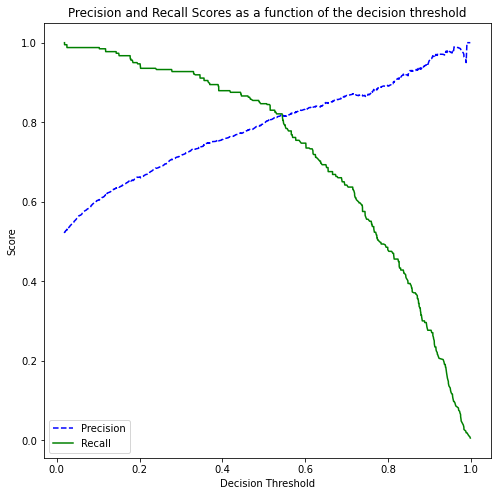

In [30]:
from sklearn.metrics import precision_recall_curve
y=train.Attrition_Yes
ypred = logit_model.predict(train)
p, r, thresholds = precision_recall_curve(y, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Classification accuracy = 79.9%
Precision = 83.4%
TPR or Recall = 74.7%
FNR = 25.3%
FPR = 14.9%
ROC-AUC = 88.3%


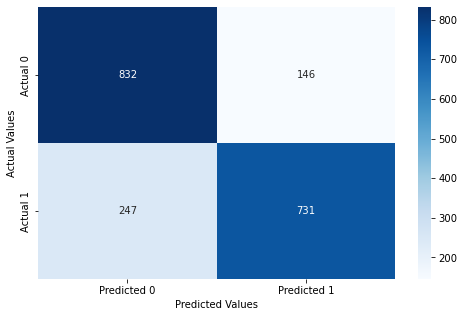

In [31]:
confusion_matrix_data(train,train.Attrition_Yes,logit_model,0.6)

Classification accuracy = 77.2%
Precision = 29.4%
TPR or Recall = 51.3%
FNR = 48.7%
FPR = 18.8%
ROC-AUC = 76.7%


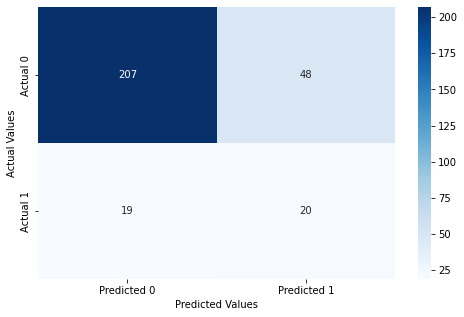

In [32]:
confusion_matrix_data(test,test.Attrition_Yes,logit_model,0.6)

0.8833519431584846


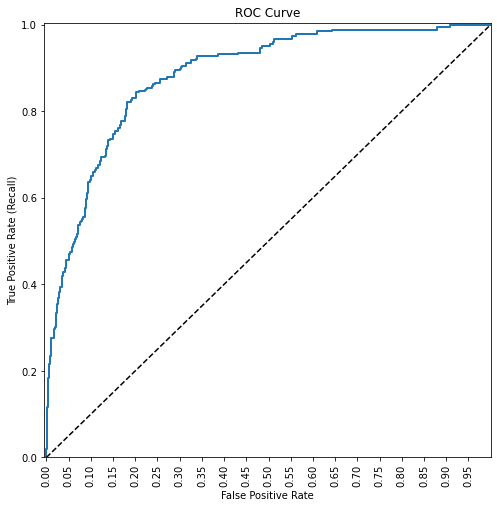

In [33]:
from sklearn.metrics import roc_curve, auc
y=train.Attrition_Yes
ypred = logit_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

In [34]:
"""
test = test.rename(columns=lambda x: x.strip())

test = pd.get_dummies(test, drop_first = True)
test.columns = test.columns.str.replace('-', '')
test.columns = test.columns.str.replace(' ', '')
test.columns = test.columns.str.replace('&', '_')
test = test.drop(["Department_Research_Development", "MonthlyIncome", "EducationField_LifeSciences", "Department_Sales"], axis = 1)
test
"""
X_train_resampled.columns


Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
       'JobSatisfaction', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_TechnicalDegree', 'Gender_Male',
       'JobRole_HumanResources', 'JobRole_LaboratoryTechnician',
       'JobRole_Manager', 'JobRole_ManufacturingDirector',
       'JobRole_ResearchDirector', 'JobRole_ResearchScientist',
       'JobRole_SalesExecutive', 'JobRole_SalesRepresentative',
       'MaritalStatus_Married', 'MaritalStatus_Sing

In [37]:
import itertools

X_backup = X_train_resampled.copy()
interactions = pd.DataFrame()

for combo in itertools.combinations(X_backup.columns, 2):
    prefix1 = combo[0][:combo[0].rfind('_')].split('_')[0]
    prefix2 = combo[1][:combo[1].rfind('_')].split('_')[0]
    if prefix1 != prefix2:
        train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
        test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
        X_train_resampled.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 
        interactions.loc[:,'_'.join(combo)] = X_train_resampled.loc[:,'_'.join(combo)]
        #only make interaction terms if the prefix(before the last underscore) of combo[0] is not the same as that of of combo[1]
        # Add the other code here under the if condition

In [40]:
interactions

,Age_DailyRate,Age_DistanceFromHome,Age_Education,Age_EmployeeNumber,Age_EnvironmentSatisfaction,Age_HourlyRate,Age_JobInvolvement,Age_JobSatisfaction,Age_MonthlyRate,Age_NumCompaniesWorked,...,JobRole_ResearchScientist_MaritalStatus_Single,JobRole_ResearchScientist_OverTime_Yes,JobRole_SalesExecutive_MaritalStatus_Married,JobRole_SalesExecutive_MaritalStatus_Single,JobRole_SalesExecutive_OverTime_Yes,JobRole_SalesRepresentative_MaritalStatus_Married,JobRole_SalesRepresentative_MaritalStatus_Single,JobRole_SalesRepresentative_OverTime_Yes,MaritalStatus_Married_OverTime_Yes,MaritalStatus_Single_OverTime_Yes
0,8400,504,48,37224,72,1368,48,24,240864,0,...,0,0,0,0,0,0,0,0,0,0
1,5166,90,36,18216,36,1314,54,72,242874,18,...,1,0,0,0,0,0,0,0,0,0
2,36163,580,58,10121,116,1305,87,116,311228,58,...,0,0,0,0,0,0,0,0,0,0
3,19188,468,117,64506,156,2574,117,78,300027,156,...,0,0,0,0,0,0,0,0,0,0
4,9641,620,93,58311,62,2759,93,93,577344,31,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,13920,120,90,15420,90,1200,90,120,102810,270,...,1,1,0,0,0,0,0,0,0,1
1952,3276,252,63,10374,63,1890,84,42,533862,21,...,0,0,0,0,0,0,1,0,0,0
1953,55596,820,82,10168,82,2870,123,82,890848,41,...,0,0,0,0,0,0,1,1,0,1
1954,28589,138,69,18653,69,1449,92,23,79235,23,...,0,0,0,0,0,0,0,0,1,0


In [35]:
## do not run this
#Creating interaction terms for all variables
"""
X_backup = X_train_resampled.copy()

interactions = pd.DataFrame()
for combo in itertools.combinations(X_backup.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
    X_train_resampled.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 
    interactions.loc[:,'_'.join(combo)] = X_train_resampled.loc[:,'_'.join(combo)]
    """
# interactions = only the interaction terms, no response variable
# X_train_resampled = interaction terms and singular predictors, no response variable
# X_backup = only singular predictors, no response variable

<AxesSubplot:>

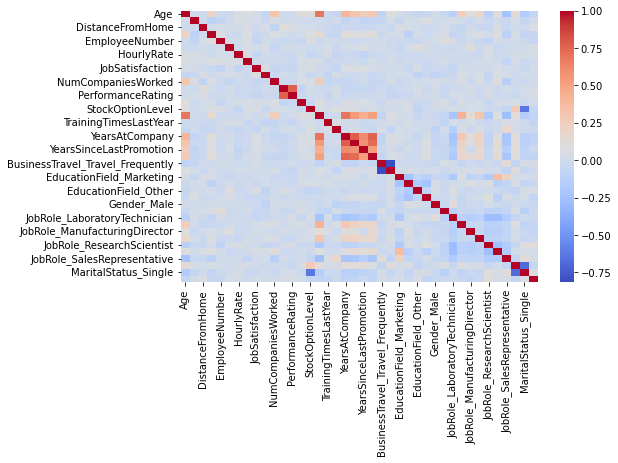

In [38]:
corr_matrix = X_backup.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')

# Dropping Interaction Terms with High VIF

In [52]:
## do not run this
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    X = X.assign(const=1)  # faster than add_constant from statsmodels
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        vif = vif[:-1]  # don't let the constant be removed in the loop.
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables[:-1]])
    return X.iloc[:, variables[:-1]]


In [51]:
interactions

,Age_DailyRate,Age_DistanceFromHome,Age_Education,Age_EmployeeNumber,Age_EnvironmentSatisfaction,Age_HourlyRate,Age_JobInvolvement,Age_JobSatisfaction,Age_MonthlyRate,Age_NumCompaniesWorked,...,JobRole_ResearchScientist_MaritalStatus_Single,JobRole_ResearchScientist_OverTime_Yes,JobRole_SalesExecutive_MaritalStatus_Married,JobRole_SalesExecutive_MaritalStatus_Single,JobRole_SalesExecutive_OverTime_Yes,JobRole_SalesRepresentative_MaritalStatus_Married,JobRole_SalesRepresentative_MaritalStatus_Single,JobRole_SalesRepresentative_OverTime_Yes,MaritalStatus_Married_OverTime_Yes,MaritalStatus_Single_OverTime_Yes
0,8400,504,48,37224,72,1368,48,24,240864,0,...,0,0,0,0,0,0,0,0,0,0
1,5166,90,36,18216,36,1314,54,72,242874,18,...,1,0,0,0,0,0,0,0,0,0
2,36163,580,58,10121,116,1305,87,116,311228,58,...,0,0,0,0,0,0,0,0,0,0
3,19188,468,117,64506,156,2574,117,78,300027,156,...,0,0,0,0,0,0,0,0,0,0
4,9641,620,93,58311,62,2759,93,93,577344,31,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,13920,120,90,15420,90,1200,90,120,102810,270,...,1,1,0,0,0,0,0,0,0,1
1952,3276,252,63,10374,63,1890,84,42,533862,21,...,0,0,0,0,0,0,1,0,0,0
1953,55596,820,82,10168,82,2870,123,82,890848,41,...,0,0,0,0,0,0,1,1,0,1
1954,28589,138,69,18653,69,1449,92,23,79235,23,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
def calc_VIF(df)

In [41]:
#Testing VIF of interaction terms
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                                               feature         VIF
0                                                const  326.078897
1                                        Age_DailyRate  154.915608
2                                 Age_DistanceFromHome  138.991411
3                                        Age_Education  200.446131
4                                   Age_EmployeeNumber  140.026855
..                                                 ...         ...
740  JobRole_SalesRepresentative_MaritalStatus_Married   35.293833
741   JobRole_SalesRepresentative_MaritalStatus_Single  102.356606
742           JobRole_SalesRepresentative_OverTime_Yes   24.440952
743                 MaritalStatus_Married_OverTime_Yes   17.251172
744                  MaritalStatus_Single_OverTime_Yes   33.572960

[745 rows x 2 columns]


In [42]:
print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature          VIF
408                   PerformanceRating_YearsAtCompany  3676.760466
18                                  Age_YearsAtCompany  3036.778721
405                PerformanceRating_TotalWorkingYears  1989.935123
409               PerformanceRating_YearsInCurrentRole  1816.985043
411             PerformanceRating_YearsWithCurrManager  1804.971153
..                                                 ...          ...
661    EducationField_Marketing_JobRole_HumanResources          NaN
662  EducationField_Marketing_JobRole_LaboratoryTec...          NaN
664  EducationField_Marketing_JobRole_Manufacturing...          NaN
665  EducationField_Marketing_JobRole_ResearchDirector          NaN
666  EducationField_Marketing_JobRole_ResearchScien...          NaN

[745 rows x 2 columns]


In [48]:
#Making a list of all null VIF values
vif_null = vif_data[vif_data.VIF.isnull()]
vif_null=vif_null.feature.to_list()

In [44]:
#Dropping null values
interactions = interactions.drop(vif_null, axis=1)
interactions

,Age_DailyRate,Age_DistanceFromHome,Age_Education,Age_EmployeeNumber,Age_EnvironmentSatisfaction,Age_HourlyRate,Age_JobInvolvement,Age_JobSatisfaction,Age_MonthlyRate,Age_NumCompaniesWorked,...,JobRole_ResearchScientist_MaritalStatus_Single,JobRole_ResearchScientist_OverTime_Yes,JobRole_SalesExecutive_MaritalStatus_Married,JobRole_SalesExecutive_MaritalStatus_Single,JobRole_SalesExecutive_OverTime_Yes,JobRole_SalesRepresentative_MaritalStatus_Married,JobRole_SalesRepresentative_MaritalStatus_Single,JobRole_SalesRepresentative_OverTime_Yes,MaritalStatus_Married_OverTime_Yes,MaritalStatus_Single_OverTime_Yes
0,8400,504,48,37224,72,1368,48,24,240864,0,...,0,0,0,0,0,0,0,0,0,0
1,5166,90,36,18216,36,1314,54,72,242874,18,...,1,0,0,0,0,0,0,0,0,0
2,36163,580,58,10121,116,1305,87,116,311228,58,...,0,0,0,0,0,0,0,0,0,0
3,19188,468,117,64506,156,2574,117,78,300027,156,...,0,0,0,0,0,0,0,0,0,0
4,9641,620,93,58311,62,2759,93,93,577344,31,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,13920,120,90,15420,90,1200,90,120,102810,270,...,1,1,0,0,0,0,0,0,0,1
1952,3276,252,63,10374,63,1890,84,42,533862,21,...,0,0,0,0,0,0,1,0,0,0
1953,55596,820,82,10168,82,2870,123,82,890848,41,...,0,0,0,0,0,0,1,1,0,1
1954,28589,138,69,18653,69,1449,92,23,79235,23,...,0,0,0,0,0,0,0,0,1,0


In [49]:
#Retesting VIF without null VIFs
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                                               feature         VIF
0                                                const  326.078897
1                                        Age_DailyRate  154.915608
2                                 Age_DistanceFromHome  138.991411
3                                        Age_Education  200.446131
4                                   Age_EmployeeNumber  140.026855
..                                                 ...         ...
734  JobRole_SalesRepresentative_MaritalStatus_Married   35.293833
735   JobRole_SalesRepresentative_MaritalStatus_Single  102.356606
736           JobRole_SalesRepresentative_OverTime_Yes   24.440952
737                 MaritalStatus_Married_OverTime_Yes   17.251172
738                  MaritalStatus_Single_OverTime_Yes   33.572960

[739 rows x 2 columns]


In [55]:
#Making a list of all VIF values greater than 200
vif_over_200 = vif_data[(vif_data["VIF"] > 200) & (vif_data["feature"] != "const")]
vif_over_200=vif_over_200.feature.to_list()

In [56]:
#Dropping values greater than 200
interactions = interactions.drop(vif_over_200, axis=1)
interactions

,Age_DailyRate,Age_DistanceFromHome,Age_EmployeeNumber,Age_EnvironmentSatisfaction,Age_JobSatisfaction,Age_MonthlyRate,Age_NumCompaniesWorked,Age_RelationshipSatisfaction,Age_TrainingTimesLastYear,Age_EducationField_Marketing,...,JobRole_ResearchScientist_MaritalStatus_Single,JobRole_ResearchScientist_OverTime_Yes,JobRole_SalesExecutive_MaritalStatus_Married,JobRole_SalesExecutive_MaritalStatus_Single,JobRole_SalesExecutive_OverTime_Yes,JobRole_SalesRepresentative_MaritalStatus_Married,JobRole_SalesRepresentative_MaritalStatus_Single,JobRole_SalesRepresentative_OverTime_Yes,MaritalStatus_Married_OverTime_Yes,MaritalStatus_Single_OverTime_Yes
0,8400,504,37224,72,24,240864,0,48,72,0,...,0,0,0,0,0,0,0,0,0,0
1,5166,90,18216,36,72,242874,18,72,36,0,...,1,0,0,0,0,0,0,0,0,0
2,36163,580,10121,116,116,311228,58,116,58,29,...,0,0,0,0,0,0,0,0,0,0
3,19188,468,64506,156,78,300027,156,117,117,0,...,0,0,0,0,0,0,0,0,0,0
4,9641,620,58311,62,93,577344,31,31,62,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,13920,120,15420,90,120,102810,270,90,120,0,...,1,1,0,0,0,0,0,0,0,1
1952,3276,252,10374,63,42,533862,21,84,0,0,...,0,0,0,0,0,0,1,0,0,0
1953,55596,820,10168,82,82,890848,41,164,205,41,...,0,0,0,0,0,0,1,1,0,1
1954,28589,138,18653,69,23,79235,23,69,46,0,...,0,0,0,0,0,0,0,0,1,0


In [57]:
#Retesting VIF without VIFs greater than 200
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

In [58]:
#Making a list of all VIF values greater than 100
vif_over_100 = vif_data[(vif_data["VIF"] > 100) & (vif_data["feature"] != "const")]
vif_over_100=vif_over_100.feature.to_list()

In [59]:
#Dropping values greater than 100
interactions = interactions.drop(vif_over_100, axis=1)

In [60]:
#Retesting VIF without VIFs greater than 100
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

In [61]:
#Making a list of all VIF values greater than 60
vif_over_60 = vif_data[(vif_data["VIF"] > 60) & (vif_data["feature"] != "const")]
vif_over_60=vif_over_60.feature.to_list()

In [62]:
#Dropping values greater than 60
interactions = interactions.drop(vif_over_60, axis=1)

In [63]:
#Retesting VIF without VIFs greater than 60
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

In [64]:
#Making a list of all VIF values greater than 30
vif_over_30 = vif_data[(vif_data["VIF"] > 30) & (vif_data["feature"] != "const")]
vif_over_30=vif_over_30.feature.to_list()

In [65]:
#Dropping values greater than 30
interactions = interactions.drop(vif_over_30, axis=1)

In [66]:
#Retesting VIF without VIFs greater than 30
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

In [67]:
#Making a list of all VIF values greater than 15
vif_over_15 = vif_data[(vif_data["VIF"] > 15) & (vif_data["feature"] != "const")]
vif_over_15=vif_over_15.feature.to_list()

In [68]:
#Dropping values greater than 15
interactions = interactions.drop(vif_over_15, axis=1)

In [69]:
#Retesting VIF without VIFs greater than 15
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

In [70]:
#Making a list of all VIF values greater than 12
vif_over_12 = vif_data[(vif_data["VIF"] > 12) & (vif_data["feature"] != "const")]
vif_over_12=vif_over_12.feature.to_list()

In [71]:
#Dropping values greater than 12
interactions = interactions.drop(vif_over_12, axis=1)

In [72]:
#Retesting VIF without VIFs greater than 12
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

In [73]:
#Making a list of all VIF values greater than 11
vif_over_11 = vif_data[(vif_data["VIF"] > 11) & (vif_data["feature"] != "const")]
vif_over_11=vif_over_11.feature.to_list()

In [74]:
#Dropping values greater than 11
interactions = interactions.drop(vif_over_11, axis=1)

In [75]:
#Retesting VIF without VIFs greater than 11
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

In [76]:
#Making a list of all VIF values greater than 10
vif_over_10 = vif_data[(vif_data["VIF"] > 10) & (vif_data["feature"] != "const")]
vif_over_10=vif_over_10.feature.to_list()

In [77]:
#Dropping values greater than 10
interactions = interactions.drop(vif_over_10, axis=1)

In [78]:
#Retesting VIF without VIFs greater than 10
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
print(vif_data)

                                               feature        VIF
0                                                const  33.118686
1                           DailyRate_DistanceFromHome   7.414709
2                             DailyRate_EmployeeNumber   8.517256
3                    DailyRate_EnvironmentSatisfaction   5.153644
4                                DailyRate_MonthlyRate   8.522574
..                                                 ...        ...
269        JobRole_SalesExecutive_MaritalStatus_Single   7.795825
270                JobRole_SalesExecutive_OverTime_Yes   8.419598
271  JobRole_SalesRepresentative_MaritalStatus_Married   4.889919
272           JobRole_SalesRepresentative_OverTime_Yes   5.764714
273                 MaritalStatus_Married_OverTime_Yes   3.725609

[274 rows x 2 columns]


In [79]:
# Interaction variables that need to be dropped due to collinearity:
interactions_to_drop = vif_null+vif_over_200+vif_over_100+vif_over_60+vif_over_30+vif_over_15+vif_over_12+vif_over_11+vif_over_10

In [80]:
# Dataframe with all predictors and interactions that have a VIF under 10, does not include response
X_train_resampled = X_train_resampled.drop(interactions_to_drop, axis=1)

In [81]:
#Retesting VIF without VIFs greater than 10
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
print(vif_data)

                                               feature          VIF
0                                                const  1446.415921
1                                                  Age     3.449460
2                                            DailyRate    51.780591
3                                     DistanceFromHome    56.513782
4                                            Education     9.739547
..                                                 ...          ...
309        JobRole_SalesExecutive_MaritalStatus_Single    21.599528
310                JobRole_SalesExecutive_OverTime_Yes    12.776098
311  JobRole_SalesRepresentative_MaritalStatus_Married     6.914077
312           JobRole_SalesRepresentative_OverTime_Yes     9.120621
313                 MaritalStatus_Married_OverTime_Yes     4.179909

[314 rows x 2 columns]


In [82]:
print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature          VIF
0                                                const  1446.415921
32                                     JobRole_Manager   140.949009
25                            EducationField_Marketing   114.916135
15                                    StockOptionLevel   105.048957
26                              EducationField_Medical   104.380572
..                                                 ...          ...
18                                     WorkLifeBalance     1.846765
262  EducationField_Other_JobRole_ManufacturingDire...     1.712819
261               EducationField_Other_JobRole_Manager     1.700862
8                                       JobInvolvement     1.660437
7                                           HourlyRate     1.629138

[314 rows x 2 columns]


# Running Forward Stepwise Selection for Singular Predictors

In [164]:
# Using DataFrame.sum() to Sum of each row
X_train_resampled_sums = X_train_resampled.sum(axis=0)
X_train_resampled_sums.sort_values(ascending = True).head(30)
###sing_mat_vars = X_train_resampled_sums.sort_values(ascending = True).head(100).index.tolist()

###train_nosingmat = X_train_resampled.drop(sing_mat_vars, axis=1)
#train_nosingmat = X_train_resampled.drop('JobRole_ResearchScientist', axis=1)

EducationField_Other_JobRole_HumanResources                        2
EducationField_Other_JobRole_Manager                               3
EducationField_TechnicalDegree_JobRole_Manager                     4
EducationField_Other_JobRole_ResearchDirector                      4
EducationField_Other_JobRole_SalesRepresentative                   5
EducationField_Other_JobRole_ManufacturingDirector                 5
JobRole_HumanResources_MaritalStatus_Single                        6
EducationField_TechnicalDegree_JobRole_HumanResources              6
EducationField_TechnicalDegree_JobRole_ResearchDirector           10
BusinessTravel_Travel_Frequently_JobRole_ResearchDirector         10
BusinessTravel_Travel_Frequently_JobRole_Manager                  11
EducationField_TechnicalDegree_JobRole_SalesExecutive             15
EducationField_TechnicalDegree_JobRole_ManufacturingDirector      16
JobRole_Manager_MaritalStatus_Single                              18
EducationField_Marketing_JobRole_M

# NEED TO ADD TRANSFORMATIONS
- For transformations, visualize them binned, and then determine transformations that could be good and then add a column of the transformation to the dataframe (for example, if there's a quadratic transformation of DailyRate, add a column to X_backup and train of DailyRate**2)

In [157]:
X_backup

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyRate,...,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,24,350,21,2,1551,3,57,2,1,10036,...,1,0,0,0,0,0,0,0,0,0
1,18,287,5,2,1012,2,73,3,4,13493,...,0,0,0,0,1,0,0,0,1,0
2,29,1247,20,2,349,4,45,3,4,10732,...,0,0,0,0,0,1,0,0,0,0
3,39,492,12,3,1654,4,66,3,2,7693,...,0,0,1,0,0,0,0,1,0,0
4,31,311,20,3,1881,2,89,3,3,18624,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,30,464,4,3,514,3,40,3,4,3427,...,0,0,0,0,1,0,0,0,1,1
1952,21,156,12,3,494,3,90,4,2,25422,...,0,0,0,0,0,0,1,0,1,0
1953,41,1356,20,2,248,2,70,3,2,21728,...,0,0,0,0,0,0,1,0,1,1
1954,23,1243,6,3,811,3,63,4,1,3445,...,1,0,0,0,0,0,0,1,0,1


In [158]:
#Creating a set of predictors from which we need to find the best subset of predictors
X = X_train_resampled[train_nosingmat.columns]
#train = pd.concat([X_backup, pd.DataFrame(y_train_resampled)],axis =1)
train = pd.concat([train_nosingmat, pd.DataFrame(y_train_resampled),],axis =1)
train

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyRate,...,BusinessTravel_Travel_Rarely_JobRole_LaboratoryTechnician,EducationField_Medical_Gender_Male,EducationField_Medical_MaritalStatus_Married,EducationField_Medical_OverTime_Yes,Gender_Male_JobRole_ResearchScientist,Gender_Male_JobRole_SalesExecutive,Gender_Male_MaritalStatus_Married,Gender_Male_OverTime_Yes,MaritalStatus_Married_OverTime_Yes,Attrition_Yes
0,24,350,21,2,1551,3,57,2,1,10036,...,1,0,0,0,0,0,0,0,0,0
1,18,287,5,2,1012,2,73,3,4,13493,...,0,0,0,0,1,0,0,0,0,0
2,29,1247,20,2,349,4,45,3,4,10732,...,0,0,0,0,0,1,0,0,0,0
3,39,492,12,3,1654,4,66,3,2,7693,...,0,1,1,0,0,0,1,0,0,0
4,31,311,20,3,1881,2,89,3,3,18624,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,30,464,4,3,514,3,40,3,4,3427,...,0,0,0,0,1,0,0,1,0,1
1952,21,156,12,3,494,3,90,4,2,25422,...,0,0,0,0,0,0,0,0,0,1
1953,41,1356,20,2,248,2,70,3,2,21728,...,0,0,0,0,0,0,0,0,0,1
1954,23,1243,6,3,811,3,63,4,1,3445,...,1,0,0,0,0,0,1,1,1,1


In [159]:
#Function to develop a model based on all predictors in predictor_subset
train = train.apply(lambda x: x.str.strip() if isinstance(x.iloc[0], str) else x)
def processSubset(predictor_subset):
    if 'Attrition_Yes' in predictor_subset:
        predictor_subset = predictor_subset.remove('Attrition_Yes')

    logit_model = sm.logit(formula = 'Attrition_Yes~' + '+'.join(predictor_subset),data = train).fit() 
    llf = logit_model.llf
    return {"logit_model":logit_model, "Log-Likelihood":llf}

In [160]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Log-Likelihood'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [161]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Log-Likelihood", "logit_model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["logit_model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [162]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.671135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692107
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693004
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692620
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693140
  

Optimization terminated successfully.
         Current function value: 0.690183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692265
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693019
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662729
  

Optimization terminated successfully.
         Current function value: 0.689863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692633
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686484
  

Optimization terminated successfully.
         Current function value: 0.626502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633648
  

Optimization terminated successfully.
         Current function value: 0.631597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631051
  

Optimization terminated successfully.
         Current function value: 0.601374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598361
  

Optimization terminated successfully.
         Current function value: 0.601082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599494
  

Optimization terminated successfully.
         Current function value: 0.595757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.600033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600564
  

Optimization terminated successfully.
         Current function value: 0.577523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.574950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567647
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.576067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.577314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.576657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.573885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.576703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.577214
  

Optimization terminated successfully.
         Current function value: 0.576009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.577012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.574076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.577477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.576903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.576524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.576439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.575542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.577331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.577140
  

Optimization terminated successfully.
         Current function value: 0.559028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.555142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.560245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.557071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.557842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.560643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.560205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.553512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559551
  

Optimization terminated successfully.
         Current function value: 0.559466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.556403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.555162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.560701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.557972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.560215
  

Processed  209 models on 5 predictors in 11.032243967056274 seconds.
Optimization terminated successfully.
         Current function value: 0.549274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550570
         Iterations 6
Optimization 

Optimization terminated successfully.
         Current function value: 0.549409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.544716
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.546821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550284
  

Optimization terminated successfully.
         Current function value: 0.550315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.544773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547225
  

Optimization terminated successfully.
         Current function value: 0.539439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.539799
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.539437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.539317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.539461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.537019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.537863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538508
  

Optimization terminated successfully.
         Current function value: 0.539640
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.539887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.537004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540418
  

Optimization terminated successfully.
         Current function value: 0.528973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528379
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528937
  

Optimization terminated successfully.
         Current function value: 0.528856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.523020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527683
  

Optimization terminated successfully.
         Current function value: 0.528963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525103
  

Optimization terminated successfully.
         Current function value: 0.516229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519368
  

Optimization terminated successfully.
         Current function value: 0.519567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519720
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518035
  

Optimization terminated successfully.
         Current function value: 0.511234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510315
  

         Current function value: 0.511244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511260
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510887
         Iterations 6
Optimization termi

Optimization terminated successfully.
         Current function value: 0.510642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509276
  

Optimization terminated successfully.
         Current function value: 0.501076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.496613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499549
  

Optimization terminated successfully.
         Current function value: 0.495921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496496
  

Optimization terminated successfully.
         Current function value: 0.489818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489385
  

Optimization terminated successfully.
         Current function value: 0.488181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491703
  

Optimization terminated successfully.
         Current function value: 0.481376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484386
  

Optimization terminated successfully.
         Current function value: 0.482287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484378
  

Optimization terminated successfully.
         Current function value: 0.483586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482715
  

Optimization terminated successfully.
         Current function value: 0.477629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477333
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477430
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477613
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.477358
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.474559
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477345
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.473171
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.476755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471168
  

Optimization terminated successfully.
         Current function value: 0.477727
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477714
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.475401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.475388
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477533
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.475586
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477615
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477563
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.476248
  

Optimization terminated successfully.
         Current function value: 0.470004
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468251
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470758
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468934
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470859
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470924
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471152
  

Optimization terminated successfully.
         Current function value: 0.471110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468932
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466338
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470141
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471000
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471168
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471163
  

Optimization terminated successfully.
         Current function value: 0.471164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470782
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469991
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470606
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470770
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470532
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470968
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470420
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470162
  

Optimization terminated successfully.
         Current function value: 0.464443
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463801
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464540
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464069
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465220
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464470
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464975
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464419
  

Optimization terminated successfully.
         Current function value: 0.463931
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463560
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464002
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463594
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461566
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461222
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464423
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463781
  

Optimization terminated successfully.
         Current function value: 0.454867
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454778
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453972
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454890
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454910
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453933
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454829
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454620
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453253
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454690
  

Optimization terminated successfully.
         Current function value: 0.454826
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452973
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454649
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452903
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454767
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.454604
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454573
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454500
  

Optimization terminated successfully.
         Current function value: 0.449878
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446857
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449748
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445968
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449916
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449616
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449933
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448081
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448501
  

Optimization terminated successfully.
         Current function value: 0.449771
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447309
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448121
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449812
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449817
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448997
  

Optimization terminated successfully.
         Current function value: 0.449628
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449825
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449899
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449822
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449574
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448445
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449652
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447045
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.449457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446359
  

Optimization terminated successfully.
         Current function value: 0.445662
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444124
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445720
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445749
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445849
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444880
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445020
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445759
  

Optimization terminated successfully.
         Current function value: 0.445164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445636
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443782
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444912
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444854
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445024
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445844
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445838
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445045
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443789
  

Optimization terminated successfully.
         Current function value: 0.438853
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441760
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440128
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440991
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440598
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441683
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441663
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441488
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441756
  

Optimization terminated successfully.
         Current function value: 0.441748
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440774
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440746
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440717
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441636
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441514
  

Optimization terminated successfully.
         Current function value: 0.440757
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441521
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441489
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441632
         Iterations 7
Processed  194 models on 20 predictors in 12.449865818023682 seconds.
Optimization terminated successfully.
         Current function value: 0.436090
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437130
         Iterations 7
Optimization

Optimization terminated successfully.
         Current function value: 0.436837
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436840
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434104
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437086
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437137
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437015
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437037
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435589
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437137
  

Optimization terminated successfully.
         Current function value: 0.435736
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437134
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436163
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436369
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435721
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437086
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435756
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436981
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437055
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437072
  

Optimization terminated successfully.
         Current function value: 0.433304
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.433289
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432957
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.433378
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.433371
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.433174
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432386
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432343
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.433019
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.431869
  

Optimization terminated successfully.
         Current function value: 0.432415
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432680
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432511
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432516
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432895
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.433395
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.433202
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.433145
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432775
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.431654
  

Optimization terminated successfully.
         Current function value: 0.428570
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429015
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429270
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.428966
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.427830
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429414
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429412
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.427479
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.428387
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.428478
  

Optimization terminated successfully.
         Current function value: 0.429355
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429259
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.427273
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429259
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429191
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429408
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429401
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.428390
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.428558
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429152
  

Optimization terminated successfully.
         Current function value: 0.429061
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429355
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.428451
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429372
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429225
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.428267
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429157
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.428666
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429199
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.428984
  

Optimization terminated successfully.
         Current function value: 0.425598
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.425978
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.426027
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.425868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.425397
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.425955
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.426003
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422897
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.426088
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.426154
  

Optimization terminated successfully.
         Current function value: 0.425952
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.424912
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.425759
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.425430
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.426125
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.425365
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.425080
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.426159
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.426016
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.426110
  

Optimization terminated successfully.
         Current function value: 0.422653
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422870
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422704
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422215
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422882
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422839
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422667
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.421724
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422066
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.421637
  

Optimization terminated successfully.
         Current function value: 0.422483
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.421767
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422698
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420516
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.421964
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422874
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422690
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422873
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422892
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.421743
  

Optimization terminated successfully.
         Current function value: 0.419996
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420232
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420273
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.419977
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.418605
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420341
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420305
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416804
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420118
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420253
  

Optimization terminated successfully.
         Current function value: 0.420266
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420345
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.418862
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420238
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.419913
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420329
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420353
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.418634
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420360
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.419986
  

Optimization terminated successfully.
         Current function value: 0.418527
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420181
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420178
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.418570
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420105
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.419500
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420289
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420281
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420116
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.420310
  

Optimization terminated successfully.
         Current function value: 0.415968
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416183
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416136
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.415940
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416093
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.415436
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416101
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416159
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416248
  

Optimization terminated successfully.
         Current function value: 0.416050
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416023
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416239
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.414482
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416204
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416031
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416185
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416266
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.415982
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416168
  

Optimization terminated successfully.
         Current function value: 0.411348
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.411452
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.410612
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.411055
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.411492
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.411777
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.412195
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.412019
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.411825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.410845
  

Optimization terminated successfully.
         Current function value: 0.411988
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.410960
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.411918
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.411947
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.411648
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.412194
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.412181
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.412071
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.411031
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.411099
  

Optimization terminated successfully.
         Current function value: 0.409021
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409578
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409573
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409385
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.408845
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409541
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409563
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409421
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409495
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409019
  

Optimization terminated successfully.
         Current function value: 0.409577
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409327
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409301
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409155
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409527
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.407668
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409559
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409576
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409064
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409255
  

Optimization terminated successfully.
         Current function value: 0.406942
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406892
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406098
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406933
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406731
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406950
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404475
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.405134
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406843
  

Optimization terminated successfully.
         Current function value: 0.406290
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406496
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406550
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406802
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406574
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406962
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406905
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404644
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406577
  

Optimization terminated successfully.
         Current function value: 0.406661
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406446
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406864
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406935
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406484
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406965
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406967
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406935
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406940
  

Optimization terminated successfully.
         Current function value: 0.403257
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.403737
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404046
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404280
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404473
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404475
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.403882
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404325
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404165
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404363
  

Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404465
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.403116
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404346
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404020
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404009
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404464
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404317
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404101
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404454
  

Optimization terminated successfully.
         Current function value: 0.402151
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.400885
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.400992
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402121
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402013
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401877
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401519
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402141
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.400211
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401874
  

Optimization terminated successfully.
         Current function value: 0.402149
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401958
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402115
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401356
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401377
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401094
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402130
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402022
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.400929
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401595
  

Optimization terminated successfully.
         Current function value: 0.398883
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398859
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397774
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397919
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398873
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398845
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398003
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398625
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398727
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398790
  

Optimization terminated successfully.
         Current function value: 0.398214
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398637
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398709
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397723
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398775
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398801
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398857
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398350
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397786
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397860
  

Optimization terminated successfully.
         Current function value: 0.396154
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.396364
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.396586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.396590
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.396596
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.396060
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.395561
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.396292
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.396600
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.395235
  

Optimization terminated successfully.
         Current function value: 0.396603
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.396550
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.394537
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.396424
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.395614
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.396566
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.395735
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.395984
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.396548
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.396071
  

Optimization terminated successfully.
         Current function value: 0.396231
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.395378
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.395886
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.396605
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.395583
         Iterations 9
Processed  180 models on 34 predictors in 18.297513961791992 seconds.
Optimization terminated successfully.
         Current function value: 0.393687
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.394099
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.392742
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.394018
         Iterations 9
Optimization

Optimization terminated successfully.
         Current function value: 0.394091
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.393586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.393687
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.394165
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.394072
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.394166
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.393378
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.394165
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.394159
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.394154
  

Optimization terminated successfully.
         Current function value: 0.392015
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.393291
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.393790
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.393992
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.393068
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.393808
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.394147
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.392037
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.394130
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.394166
 

Optimization terminated successfully.
         Current function value: 0.391180
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391959
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391797
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.389955
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391454
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391752
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391969
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391963
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391970
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391587
  

Optimization terminated successfully.
         Current function value: 0.391092
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.390144
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391371
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391970
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391918
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391970
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391850
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391524
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391320
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391821
  

LinAlgError: Singular matrix

In [101]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Log-Likelihood"])
    plt.xlabel('# Predictors')
    plt.ylabel('Log-Likelihood')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    """
    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('psuedo rsquared')
    """

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

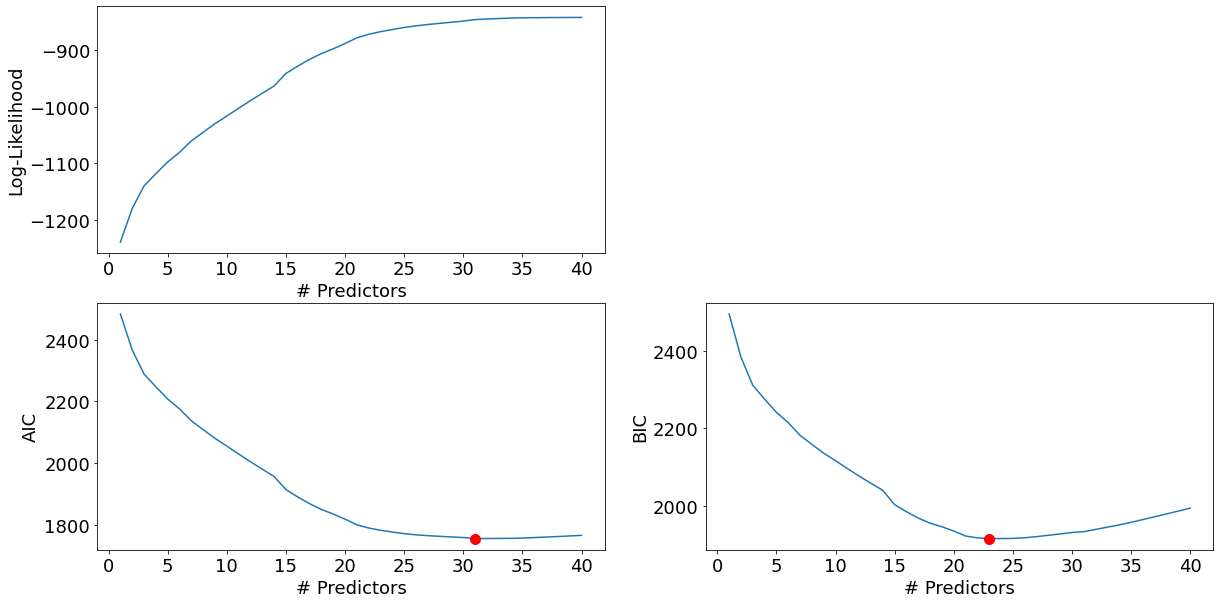

In [102]:
best_sub_plots()

In [103]:
singular_fwd_reg_model = models_best['logit_model'][23]
singular_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1956
Model:                          Logit   Df Residuals:                     1932
Method:                           MLE   Df Model:                           23
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.3604
Time:                        20:33:28   Log-Likelihood:                -867.16
converged:                       True   LL-Null:                       -1355.8
Covariance Type:            nonrobust   LLR p-value:                9.025e-192
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.4747      0.523      0.907      0.365      -0.551       1.501
OverTime_Yes                         2.0229      0.133     15.197      0.000       1.762       2.284
MaritalStatus_Single                 1.9409      0.185     10.485      0.000       1.578       2.304
TotalWorkingYears                   -0.1109      0.015     -7.451      0.000      -0.140      -0.082
NumCompaniesWorked                   0.1731      0.026      6.571      0.000       0.121       0.225
JobInvolvement                      -0.5027      0.088     -5.708      0.000      -0.675      -0.330
JobRole_LaboratoryTechnician         1.3381      0.165      8.095      0.000       1.014       1.662
JobRole_SalesRepresentative          1.7699      0.244      7.243      0.000       1.291       2.249
WorkLifeBalance                     -0.4823      0.085     -5.693      0.000      -0.648      -0.316
JobSatisfaction                     -0.3261      0.056     -5.863      0.000      -0.435      -0.217
EducationField_TechnicalDegree       1.4763      0.206      7.180      0.000       1.073       1.879
EnvironmentSatisfaction             -0.3310      0.057     -5.805      0.000      -0.443      -0.219
BusinessTravel_Travel_Frequently     1.8660      0.277      6.739      0.000       1.323       2.409
YearsSinceLastPromotion              0.1251      0.026      4.804      0.000       0.074       0.176
YearsInCurrentRole                  -0.2015      0.031     -6.486      0.000      -0.262      -0.141
YearsAtCompany                       0.1909      0.023      8.180      0.000       0.145       0.237
DistanceFromHome                     0.0397      0.008      5.225      0.000       0.025       0.055
YearsWithCurrManager                -0.1371      0.029     -4.775      0.000      -0.193      -0.081
BusinessTravel_Travel_Rarely         1.1830      0.252      4.685      0.000       0.688       1.678
MaritalStatus_Married                0.7676      0.173      4.429      0.000       0.428       1.107
JobRole_HumanResources               1.4570      0.298      4.883      0.000       0.872       2.042
JobRole_SalesExecutive               0.7838      0.167      4.681      0.000       0.456       1.112
Gender_Male                          0.4417      0.126      3.497      0.000       0.194       0.689
TrainingTimesLastYear               -0.1456      0.048     -3.044      0.002      -0.239      -0.052
====================================================================================================
"""

# Backward Selection

In [119]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [120]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [121]:
models_best = backward_selection()

         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

# Forward Selection of Interaction Terms Only

In [78]:
interactions.head()

,DailyRate_DistanceFromHome,DailyRate_EmployeeNumber,DailyRate_EnvironmentSatisfaction,DailyRate_MonthlyRate,DailyRate_NumCompaniesWorked,DailyRate_StockOptionLevel,DailyRate_TrainingTimesLastYear,DailyRate_YearsSinceLastPromotion,DailyRate_YearsWithCurrManager,DailyRate_BusinessTravel_Travel_Frequently,...,JobRole_ResearchDirector_OverTime_Yes,JobRole_ResearchScientist_MaritalStatus_Married,JobRole_ResearchScientist_MaritalStatus_Single,JobRole_ResearchScientist_OverTime_Yes,JobRole_SalesExecutive_MaritalStatus_Married,JobRole_SalesExecutive_MaritalStatus_Single,JobRole_SalesExecutive_OverTime_Yes,JobRole_SalesRepresentative_MaritalStatus_Married,JobRole_SalesRepresentative_OverTime_Yes,MaritalStatus_Married_OverTime_Yes
0,7350,542850,1050,3512600,0,1050,1050,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1435,290444,574,3872491,287,0,574,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,24940,435203,4988,13382804,2494,1247,2494,0,2494,0,...,0,0,0,0,0,0,0,0,0,0
3,5904,813768,1968,3784956,1968,0,1476,492,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6220,584991,622,5792064,311,311,622,0,622,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
#Retesting VIF without VIFs greater than 10
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
print(vif_data)

                                               feature        VIF
0                                                const  33.118686
1                           DailyRate_DistanceFromHome   7.414709
2                             DailyRate_EmployeeNumber   8.517256
3                    DailyRate_EnvironmentSatisfaction   5.153644
4                                DailyRate_MonthlyRate   8.522574
..                                                 ...        ...
269        JobRole_SalesExecutive_MaritalStatus_Single   7.795825
270                JobRole_SalesExecutive_OverTime_Yes   8.419598
271  JobRole_SalesRepresentative_MaritalStatus_Married   4.889919
272           JobRole_SalesRepresentative_OverTime_Yes   5.764714
273                 MaritalStatus_Married_OverTime_Yes   3.725609

[274 rows x 2 columns]


In [80]:
#Making a list of all VIF values greater than 10
vif_over_5 = vif_data[(vif_data["VIF"] > 5) & (vif_data["feature"] != "const")]
vif_over_5=vif_over_5.feature.to_list()

In [81]:
#Dropping values greater than 10
interactions = interactions.drop(vif_over_5, axis=1)

In [82]:
#Retesting VIF without VIFs greater than 10
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
print(vif_data)

                                              feature       VIF
0                                               const  6.853067
1                 DistanceFromHome_NumCompaniesWorked  1.918100
2   DistanceFromHome_BusinessTravel_Travel_Frequently  2.519446
3             DistanceFromHome_EducationField_Medical  2.042997
4               DistanceFromHome_EducationField_Other  2.555447
..                                                ...       ...
87     JobRole_ResearchDirector_MaritalStatus_Married  2.569274
88      JobRole_ResearchDirector_MaritalStatus_Single  2.444313
89              JobRole_ResearchDirector_OverTime_Yes  1.775864
90  JobRole_SalesRepresentative_MaritalStatus_Married  1.993611
91                 MaritalStatus_Married_OverTime_Yes  2.050677

[92 rows x 2 columns]


In [95]:
#Creating a set of predictors from which we need to find the best subset of predictors
# putting interactions and X_backup in same df
X = interactions[interactions.columns]
train = pd.concat([interactions, pd.DataFrame(y_train_resampled),],axis =1)
#train = pd.concat([X_backup, interactions, pd.DataFrame(y_train_resampled),],axis =1)

In [84]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.690970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693127
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693061
  

Optimization terminated successfully.
         Current function value: 0.692414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686601
         Iterations 4
Processed  91 models on 1 predictors in 0.6415307521820068 seconds.
Optimization terminated successfully.
         Current function value: 0.647672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646193
         Iterations 5
Optimization t

Optimization terminated successfully.
         Current function value: 0.645252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640212
         Iterations 5
         Current function value: 0.645256
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.647712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646380
         Iterations 5
Optimization ter

LinAlgError: Singular matrix

In [ ]:
print(vif_data.sort_values(by = 'VIF', ascending = False))

In [ ]:
#Function to develop a model based on all predictors in predictor_subset
# X = train.drop(["Attrition_Yes",'JobRole','OverTime'], axis = 1)
## X = X.rename(columns=lambda x: x.strip())
## X['JobRole'] = X['JobRole'].astype(str)

train = train.apply(lambda x: x.str.strip() if isinstance(x.iloc[0], str) else x)
def processSubset(predictor_subset):
    if 'Attrition_Yes' in predictor_subset:
        predictor_subset = predictor_subset.remove('Attrition_Yes')

    # Fit model on feature_set and calculate R-squared
    #model = sm.ols('Attrition_Yes~' + '+'.join(predictor_subset),data = train_num).fit()
    #Developing logistic regression model
    logit_model = sm.logit(formula = 'Attrition_Yes~' + '+'.join(predictor_subset),data = train).fit() 
    llf = logit_model.llf
    return {"logit_model":logit_model, "Log-Likelihood":llf}

In [ ]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
import time
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train_resampled.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        print(p)
        results.append(processSubset(predictors+[p]))
        
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Log-Likelihood'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Log-Likelihood", "logit_model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X_train_resampled.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["logit_model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

#make dummies for all categorical variables
#change R-squared to log likelihood, keep AIC and BIC
#show all three graphs in
#check for multi-collinearity among all variables first, remove the ones that are colinear (decide which one is most important), then do forward stepwise - use VIF score, (email Krish about what threshold to use, 5 and below you should be good) if they're above the threshold point, remove them
#change predictors to be dummies rather than just dummy variables because forward selection might decide that one of them isn't important and not include them - less of a priority, but if we have time

In [ ]:
models_best = forward_selection()

In [ ]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Log-Likelihood"])
    plt.xlabel('# Predictors')
    plt.ylabel('Log-Likelihood')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    """
    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('psuedo rsquared')
    """

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [ ]:
best_fwd_reg_model = models_best['logit_model'][25]
best_fwd_reg_model.summary()

In [ ]:
confusion_matrix_data(train,train.Attrition_Yes,best_fwd_reg_model,0.5)

In [ ]:
# confusion_matrix_test(test,test.Attrition_Yes,best_fwd_reg_model,0.55)

In [ ]:
from sklearn.metrics import roc_curve, auc
y=train.Attrition_Yes
ypred = best_fwd_reg_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

# Adding interactions and transformations

In [ ]:
def recall(data, actual_values, model, cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    print("TPR or Recall = {:.1%}".format(tpr))

In [ ]:
## brute force interaction terms
## goal is to maximize recall

log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)
# class_acc(data = test, actual_values = test.Attrition_Yes, model = log_model)

In [ ]:
# Made DistanceFromHome quadratic
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
# made TrainingTimesLastYear quadratic
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + (DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
confusion_matrix_data(train, train.Attrition_Yes,log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobLevel*EducationField_TechnicalDegree+ JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobLevel*EducationField_TechnicalDegree + JobInvolvement + JobRole_ResearchScientist*YearsWithCurrManager + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobLevel*EducationField_TechnicalDegree + JobInvolvement + JobRole_ResearchScientist*YearsWithCurrManager + JobRole_ResearchScientist*NumCompaniesWorked + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobLevel*EducationField_TechnicalDegree + JobInvolvement + JobRole_ResearchScientist*YearsWithCurrManager + JobRole_ResearchScientist*NumCompaniesWorked + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction*JobRole_HumanResources + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobLevel*EducationField_TechnicalDegree + JobInvolvement + JobRole_ResearchScientist*YearsWithCurrManager + JobRole_ResearchScientist*NumCompaniesWorked + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction*JobRole_HumanResources + BusinessTravel_Travel_Frequently*DistanceFromHome + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobLevel*EducationField_TechnicalDegree + JobInvolvement + JobRole_ResearchScientist*YearsWithCurrManager + JobRole_ResearchScientist*NumCompaniesWorked + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction*JobRole_HumanResources + BusinessTravel_Travel_Frequently*DistanceFromHome + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome*JobRole_SalesExecutive + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single*JobSatisfaction + MaritalStatus_Single*YearsInCurrentRole+ MaritalStatus_Single*NumCompaniesWorked + JobLevel*JobRole_ResearchScientist + JobLevel*EducationField_TechnicalDegree + JobInvolvement + JobRole_ResearchScientist*YearsWithCurrManager + JobRole_ResearchScientist*NumCompaniesWorked + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction*JobRole_HumanResources + BusinessTravel_Travel_Frequently*DistanceFromHome + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome*JobRole_SalesExecutive + I(DistanceFromHome**2) + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + I(TrainingTimesLastYear**2) + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
recall(data = train, actual_values = train.Attrition_Yes, model = log_model)
log_model.summary()

In [ ]:
confusion_matrix_data(train,train.Attrition_Yes,log_model)

In [ ]:
from sklearn.metrics import roc_curve, auc
y=train.Attrition_Yes
ypred = log_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

In [ ]:
test.shape
70/371
100-18.8

In [ ]:
confusion_matrix_data(test, test.Attrition_Yes, log_model)

In [ ]:
from sklearn.metrics import roc_curve, auc
y=test.Attrition_Yes
ypred = log_model.predict(test)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

## The code below this is useless

In [ ]:
#Binning YearsAtCompany
def var_transform(data, train_values, data_values):
    binned = pd.qcut(train_values,10,retbins=True, duplicates = 'drop')
    bins = binned[1]
    data['binned'] = pd.cut(data_values,bins = bins)
    dum = pd.get_dummies(data.binned,drop_first = True)
    dum.columns = ['name'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

In [ ]:
train = var_transform(train, train.YearsAtCompany, train.YearsAtCompany)

data = train.groupby('binned')['Attrition_Yes'].agg([('percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = data.index, y= data['percent'])
plt.xlabel('bin')

In [ ]:
sns.lineplot(x = age_data.index, y= age_data['attrition_percent'])
plt.xlabel('Age_bin')


In [ ]:
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(train.Age,0), y = jitter(train.attrition_percent,0), data = train, color = 'orange')
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
logit_model = sm.logit(formula = 'Outcome~Age+I(Age**2)', data = train).fit()
sns.lineplot(x = 'Age', y= logit_model.predict(train), data = train, color = 'blue') 
logit_model.llf

In [ ]:
log_model = sm.logit(formula = 'Attrition_Yes ~ OverTime_Yes + MaritalStatus_Single + JobLevel + JobInvolvement + JobRole_ResearchScientist + EducationField_TechnicalDegree + EnvironmentSatisfaction + WorkLifeBalance + JobSatisfaction + BusinessTravel_Travel_Frequently + YearsInCurrentRole + YearsSinceLastPromotion + BusinessTravel_Travel_Rarely + DistanceFromHome + YearsAtCompany + YearsWithCurrManager + NumCompaniesWorked + TotalWorkingYears + MaritalStatus_Married + Gender_Male + TrainingTimesLastYear + JobRole_SalesRepresentative + JobRole_LaboratoryTechnician + JobRole_HumanResources + JobRole_SalesExecutive', data = train).fit()
class_acc(data = train, actual_values = train.Attrition_Yes, model = log_model)


In [ ]:
#interactions: consider all possible - do what we did in Assignment E, include all 2 interactions with stepwise
#might consider 3-factor interactions
#don't do interactions for variables that are the same level

In [ ]:
interactions_to_drop = ['StockOptionLevel_MaritalStatus_Single','BusinessTravel_Travel_Frequently_BusinessTravel_Travel_Rarely','EducationField_Marketing_EducationField_Medical', 'EducationField_Marketing_EducationField_Other',
 'EducationField_Marketing_EducationField_TechnicalDegree','EducationField_Marketing_JobRole_HumanResources','EducationField_Marketing_JobRole_LaboratoryTechnician','EducationField_Marketing_JobRole_ManufacturingDirector',
 'EducationField_Marketing_JobRole_ResearchDirector','EducationField_Marketing_JobRole_ResearchScientist','EducationField_Medical_EducationField_Other','EducationField_Medical_EducationField_TechnicalDegree',
 'EducationField_Other_EducationField_TechnicalDegree','JobRole_HumanResources_JobRole_LaboratoryTechnician','JobRole_HumanResources_JobRole_Manager','JobRole_HumanResources_JobRole_ManufacturingDirector',
 'JobRole_HumanResources_JobRole_ResearchDirector','JobRole_HumanResources_JobRole_ResearchScientist','JobRole_HumanResources_JobRole_SalesExecutive','JobRole_HumanResources_JobRole_SalesRepresentative',
 'JobRole_LaboratoryTechnician_JobRole_Manager','JobRole_LaboratoryTechnician_JobRole_ManufacturingDirector','JobRole_LaboratoryTechnician_JobRole_ResearchDirector','JobRole_LaboratoryTechnician_JobRole_ResearchScientist',
 'JobRole_LaboratoryTechnician_JobRole_SalesExecutive','JobRole_LaboratoryTechnician_JobRole_SalesRepresentative','JobRole_Manager_JobRole_ManufacturingDirector','JobRole_Manager_JobRole_ResearchDirector',
 'JobRole_Manager_JobRole_ResearchScientist','JobRole_Manager_JobRole_SalesExecutive','JobRole_Manager_JobRole_SalesRepresentative','JobRole_ManufacturingDirector_JobRole_ResearchDirector',
 'JobRole_ManufacturingDirector_JobRole_ResearchScientist','JobRole_ManufacturingDirector_JobRole_SalesExecutive','JobRole_ManufacturingDirector_JobRole_SalesRepresentative','JobRole_ResearchDirector_JobRole_ResearchScientist',
 'JobRole_ResearchDirector_JobRole_SalesExecutive','JobRole_ResearchDirector_JobRole_SalesRepresentative','JobRole_ResearchScientist_JobRole_SalesExecutive','JobRole_ResearchScientist_JobRole_SalesRepresentative',
 'JobRole_SalesExecutive_JobRole_SalesRepresentative','MaritalStatus_Married_MaritalStatus_Single','Age_Education','Age_HourlyRate',
 'Age_JobInvolvement','Age_PercentSalaryHike','Age_PerformanceRating','Age_StockOptionLevel','Age_TotalWorkingYears','Age_WorkLifeBalance',
 'Age_YearsAtCompany','Age_YearsInCurrentRole','Age_YearsSinceLastPromotion','Age_YearsWithCurrManager','Age_BusinessTravel_Travel_Frequently',
 'Age_BusinessTravel_Travel_Rarely','Age_EducationField_Other','Age_JobRole_HumanResources','Age_JobRole_LaboratoryTechnician','Age_JobRole_Manager',
 'Age_JobRole_ManufacturingDirector','Age_JobRole_ResearchDirector','Age_JobRole_ResearchScientist','Age_JobRole_SalesExecutive','Age_JobRole_SalesRepresentative',
 'Age_MaritalStatus_Married','Age_MaritalStatus_Single','DailyRate_PerformanceRating','DistanceFromHome_PerformanceRating','Education_PercentSalaryHike',
 'Education_PerformanceRating','Education_TotalWorkingYears','Education_YearsAtCompany','EmployeeNumber_PerformanceRating','EnvironmentSatisfaction_PerformanceRating','EnvironmentSatisfaction_YearsAtCompany',
 'HourlyRate_PercentSalaryHike','HourlyRate_PerformanceRating','HourlyRate_TotalWorkingYears','HourlyRate_YearsAtCompany','JobInvolvement_PercentSalaryHike','JobInvolvement_PerformanceRating',
 'JobInvolvement_TotalWorkingYears',
 'JobInvolvement_YearsAtCompany',
 'JobInvolvement_YearsInCurrentRole',
 'JobInvolvement_YearsWithCurrManager',
 'JobSatisfaction_PercentSalaryHike',
 'JobSatisfaction_PerformanceRating',
 'JobSatisfaction_YearsAtCompany',
 'MonthlyRate_PerformanceRating',
 'NumCompaniesWorked_PercentSalaryHike',
 'NumCompaniesWorked_PerformanceRating',
 'PercentSalaryHike_PerformanceRating',
 'PercentSalaryHike_StockOptionLevel',
 'PercentSalaryHike_TotalWorkingYears',
 'PercentSalaryHike_WorkLifeBalance',
 'PercentSalaryHike_YearsAtCompany',
 'PercentSalaryHike_YearsInCurrentRole',
 'PercentSalaryHike_YearsSinceLastPromotion',
 'PercentSalaryHike_YearsWithCurrManager',
 'PercentSalaryHike_BusinessTravel_Travel_Frequently',
 'PercentSalaryHike_BusinessTravel_Travel_Rarely',
 'PercentSalaryHike_EducationField_Marketing',
 'PercentSalaryHike_EducationField_Other',
 'PercentSalaryHike_EducationField_TechnicalDegree',
 'PercentSalaryHike_JobRole_HumanResources',
 'PercentSalaryHike_JobRole_LaboratoryTechnician',
 'PercentSalaryHike_JobRole_Manager',
 'PercentSalaryHike_JobRole_ManufacturingDirector',
 'PercentSalaryHike_JobRole_ResearchScientist',
 'PercentSalaryHike_JobRole_SalesExecutive',
 'PercentSalaryHike_JobRole_SalesRepresentative',
 'PercentSalaryHike_MaritalStatus_Married',
 'PercentSalaryHike_MaritalStatus_Single',
 'PerformanceRating_RelationshipSatisfaction',
 'PerformanceRating_StockOptionLevel',
 'PerformanceRating_TotalWorkingYears',
 'PerformanceRating_TrainingTimesLastYear',
 'PerformanceRating_WorkLifeBalance',
 'PerformanceRating_YearsAtCompany',
 'PerformanceRating_YearsInCurrentRole',
 'PerformanceRating_YearsSinceLastPromotion',
 'PerformanceRating_YearsWithCurrManager',
 'PerformanceRating_BusinessTravel_Travel_Frequently',
 'PerformanceRating_BusinessTravel_Travel_Rarely',
 'PerformanceRating_EducationField_Marketing',
 'PerformanceRating_EducationField_Medical',
 'PerformanceRating_EducationField_Other',
 'PerformanceRating_EducationField_TechnicalDegree',
 'PerformanceRating_Gender_Male',
 'PerformanceRating_JobRole_HumanResources',
 'PerformanceRating_JobRole_LaboratoryTechnician',
 'PerformanceRating_JobRole_Manager',
 'PerformanceRating_JobRole_ManufacturingDirector',
 'PerformanceRating_JobRole_ResearchDirector',
 'PerformanceRating_JobRole_ResearchScientist',
 'PerformanceRating_JobRole_SalesExecutive',
 'PerformanceRating_JobRole_SalesRepresentative',
 'PerformanceRating_MaritalStatus_Married',
 'PerformanceRating_MaritalStatus_Single',
 'PerformanceRating_OverTime_Yes',
 'RelationshipSatisfaction_TotalWorkingYears',
 'RelationshipSatisfaction_YearsAtCompany',
 'TotalWorkingYears_WorkLifeBalance',
 'TotalWorkingYears_YearsAtCompany',
 'TotalWorkingYears_YearsInCurrentRole',
 'TotalWorkingYears_YearsSinceLastPromotion',
 'TotalWorkingYears_YearsWithCurrManager',
 'TotalWorkingYears_BusinessTravel_Travel_Rarely',
 'TotalWorkingYears_JobRole_Manager',
 'TotalWorkingYears_JobRole_ResearchDirector',
 'TrainingTimesLastYear_YearsAtCompany',
 'WorkLifeBalance_YearsAtCompany',
 'WorkLifeBalance_YearsInCurrentRole',
 'WorkLifeBalance_YearsWithCurrManager',
 'WorkLifeBalance_JobRole_HumanResources',
 'WorkLifeBalance_JobRole_SalesRepresentative',
 'YearsAtCompany_YearsInCurrentRole',
 'YearsAtCompany_YearsSinceLastPromotion',
 'YearsAtCompany_YearsWithCurrManager',
 'YearsAtCompany_BusinessTravel_Travel_Rarely',
 'EducationField_Marketing_JobRole_SalesExecutive',
 'EducationField_Marketing_JobRole_SalesRepresentative',
 'Age_DailyRate',
 'Age_EnvironmentSatisfaction',
 'Age_JobSatisfaction',
 'Age_MonthlyRate',
 'Age_EducationField_TechnicalDegree',
 'HourlyRate_MaritalStatus_Single',
 'JobInvolvement_JobRole_LaboratoryTechnician',
 'JobInvolvement_JobRole_SalesExecutive',
 'JobInvolvement_MaritalStatus_Single',
 'MonthlyRate_YearsAtCompany',
 'StockOptionLevel_WorkLifeBalance',
 'TotalWorkingYears_JobRole_HumanResources',
 'WorkLifeBalance_BusinessTravel_Travel_Frequently',
 'WorkLifeBalance_BusinessTravel_Travel_Rarely',
 'WorkLifeBalance_MaritalStatus_Single',
 'YearsAtCompany_JobRole_HumanResources',
 'YearsInCurrentRole_EducationField_Other',
 'Age_DistanceFromHome',
 'Age_EmployeeNumber',
 'Age_NumCompaniesWorked',
 'Age_RelationshipSatisfaction',
 'Age_TrainingTimesLastYear',
 'Age_EducationField_Marketing',
 'Age_EducationField_Medical',
 'Age_Gender_Male',
 'Age_OverTime_Yes',
 'DailyRate_YearsAtCompany',
 'Education_YearsInCurrentRole',
 'Education_YearsWithCurrManager',
 'Education_BusinessTravel_Travel_Frequently',
 'Education_BusinessTravel_Travel_Rarely',
 'Education_JobRole_HumanResources',
 'Education_JobRole_LaboratoryTechnician',
 'Education_JobRole_ResearchScientist',
 'Education_JobRole_SalesExecutive',
 'Education_MaritalStatus_Single',
 'EmployeeNumber_YearsAtCompany',
 'EnvironmentSatisfaction_TotalWorkingYears',
 'EnvironmentSatisfaction_YearsInCurrentRole',
 'EnvironmentSatisfaction_BusinessTravel_Travel_Rarely',
 'EnvironmentSatisfaction_MaritalStatus_Single',
 'HourlyRate_YearsInCurrentRole',
 'HourlyRate_YearsWithCurrManager',
 'HourlyRate_BusinessTravel_Travel_Frequently',
 'HourlyRate_BusinessTravel_Travel_Rarely',
 'HourlyRate_JobRole_HumanResources',
 'HourlyRate_JobRole_LaboratoryTechnician',
 'HourlyRate_JobRole_ResearchScientist',
 'HourlyRate_JobRole_SalesExecutive',
 'HourlyRate_JobRole_SalesRepresentative',
 'JobInvolvement_BusinessTravel_Travel_Frequently',
 'JobInvolvement_BusinessTravel_Travel_Rarely',
 'JobInvolvement_EducationField_TechnicalDegree',
 'JobInvolvement_JobRole_HumanResources',
 'JobSatisfaction_TotalWorkingYears',
 'JobSatisfaction_BusinessTravel_Travel_Rarely',
 'JobSatisfaction_EducationField_Other',
 'JobSatisfaction_MaritalStatus_Single',
 'MonthlyRate_BusinessTravel_Travel_Rarely',
 'RelationshipSatisfaction_YearsInCurrentRole',
 'RelationshipSatisfaction_BusinessTravel_Travel_Rarely',
 'StockOptionLevel_YearsAtCompany',
 'TotalWorkingYears_TrainingTimesLastYear',
 'WorkLifeBalance_EducationField_Marketing',
 'WorkLifeBalance_EducationField_Other',
 'WorkLifeBalance_JobRole_LaboratoryTechnician',
 'WorkLifeBalance_JobRole_ResearchDirector',
 'WorkLifeBalance_JobRole_ResearchScientist',
 'WorkLifeBalance_JobRole_SalesExecutive',
 'YearsAtCompany_EducationField_TechnicalDegree',
 'YearsAtCompany_JobRole_Manager',
 'YearsAtCompany_JobRole_ManufacturingDirector',
 'YearsAtCompany_JobRole_ResearchDirector',
 'YearsAtCompany_JobRole_ResearchScientist',
 'YearsAtCompany_JobRole_SalesExecutive',
 'YearsAtCompany_MaritalStatus_Married',
 'YearsAtCompany_MaritalStatus_Single',
 'YearsInCurrentRole_BusinessTravel_Travel_Rarely',
 'YearsWithCurrManager_BusinessTravel_Travel_Rarely',
 'YearsWithCurrManager_MaritalStatus_Single',
 'BusinessTravel_Travel_Rarely_JobRole_ResearchDirector',
 'BusinessTravel_Travel_Rarely_JobRole_ResearchScientist',
 'BusinessTravel_Travel_Rarely_JobRole_SalesExecutive',
 'BusinessTravel_Travel_Rarely_MaritalStatus_Single',
 'JobRole_SalesRepresentative_MaritalStatus_Single',
 'DailyRate_HourlyRate',
 'DailyRate_JobInvolvement',
 'DailyRate_PercentSalaryHike',
 'DailyRate_TotalWorkingYears',
 'DailyRate_WorkLifeBalance',
 'DailyRate_YearsInCurrentRole',
 'DailyRate_BusinessTravel_Travel_Rarely',
 'DailyRate_JobRole_LaboratoryTechnician',
 'DailyRate_JobRole_ResearchScientist',
 'DailyRate_JobRole_SalesExecutive',
 'DailyRate_MaritalStatus_Single',
 'DistanceFromHome_JobInvolvement',
 'DistanceFromHome_PercentSalaryHike',
 'DistanceFromHome_WorkLifeBalance',
 'DistanceFromHome_YearsAtCompany',
 'Education_EmployeeNumber',
 'Education_EnvironmentSatisfaction',
 'Education_HourlyRate',
 'Education_JobInvolvement',
 'Education_MonthlyRate',
 'Education_NumCompaniesWorked',
 'Education_WorkLifeBalance',
 'Education_YearsSinceLastPromotion',
 'Education_EducationField_Other',
 'Education_EducationField_TechnicalDegree',
 'EmployeeNumber_HourlyRate',
 'EmployeeNumber_JobInvolvement',
 'EmployeeNumber_PercentSalaryHike',
 'EmployeeNumber_TotalWorkingYears',
 'EmployeeNumber_WorkLifeBalance',
 'EmployeeNumber_YearsInCurrentRole',
 'EmployeeNumber_YearsWithCurrManager',
 'EmployeeNumber_BusinessTravel_Travel_Rarely',
 'EmployeeNumber_MaritalStatus_Single',
 'EnvironmentSatisfaction_HourlyRate',
 'EnvironmentSatisfaction_JobInvolvement',
 'EnvironmentSatisfaction_JobSatisfaction',
 'EnvironmentSatisfaction_PercentSalaryHike',
 'EnvironmentSatisfaction_WorkLifeBalance',
 'EnvironmentSatisfaction_EducationField_Other',
 'EnvironmentSatisfaction_JobRole_LaboratoryTechnician',
 'EnvironmentSatisfaction_JobRole_ManufacturingDirector',
 'EnvironmentSatisfaction_JobRole_ResearchScientist',
 'EnvironmentSatisfaction_JobRole_SalesExecutive',
 'EnvironmentSatisfaction_JobRole_SalesRepresentative',
 'HourlyRate_JobInvolvement',
 'HourlyRate_JobSatisfaction',
 'HourlyRate_MonthlyRate',
 'HourlyRate_NumCompaniesWorked',
 'HourlyRate_RelationshipSatisfaction',
 'HourlyRate_TrainingTimesLastYear',
 'HourlyRate_WorkLifeBalance',
 'HourlyRate_EducationField_Marketing',
 'HourlyRate_EducationField_Other',
 'HourlyRate_EducationField_TechnicalDegree',
 'HourlyRate_OverTime_Yes',
 'JobInvolvement_JobSatisfaction',
 'JobInvolvement_MonthlyRate',
 'JobInvolvement_NumCompaniesWorked',
 'JobInvolvement_RelationshipSatisfaction',
 'JobInvolvement_StockOptionLevel',
 'JobInvolvement_TrainingTimesLastYear',
 'JobInvolvement_WorkLifeBalance',
 'JobInvolvement_YearsSinceLastPromotion',
 'JobInvolvement_EducationField_Marketing',
 'JobInvolvement_EducationField_Medical',
 'JobInvolvement_EducationField_Other',
 'JobInvolvement_Gender_Male',
 'JobInvolvement_JobRole_Manager',
 'JobInvolvement_JobRole_ManufacturingDirector',
 'JobInvolvement_JobRole_ResearchScientist',
 'JobInvolvement_JobRole_SalesRepresentative',
 'JobInvolvement_MaritalStatus_Married',
 'JobInvolvement_OverTime_Yes',
 'JobSatisfaction_RelationshipSatisfaction',
 'JobSatisfaction_WorkLifeBalance',
 'JobSatisfaction_YearsInCurrentRole',
 'JobSatisfaction_YearsSinceLastPromotion',
 'JobSatisfaction_YearsWithCurrManager',
 'JobSatisfaction_JobRole_HumanResources',
 'JobSatisfaction_JobRole_LaboratoryTechnician',
 'JobSatisfaction_JobRole_ResearchScientist',
 'JobSatisfaction_JobRole_SalesExecutive',
 'JobSatisfaction_JobRole_SalesRepresentative',
 'MonthlyRate_PercentSalaryHike',
 'MonthlyRate_TotalWorkingYears',
 'MonthlyRate_WorkLifeBalance',
 'MonthlyRate_YearsInCurrentRole',
 'MonthlyRate_YearsWithCurrManager',
 'MonthlyRate_JobRole_LaboratoryTechnician',
 'MonthlyRate_JobRole_ResearchScientist',
 'MonthlyRate_JobRole_SalesExecutive',
 'MonthlyRate_JobRole_SalesRepresentative',
 'MonthlyRate_MaritalStatus_Single',
 'NumCompaniesWorked_TotalWorkingYears',
 'NumCompaniesWorked_WorkLifeBalance',
 'NumCompaniesWorked_YearsAtCompany',
 'PercentSalaryHike_RelationshipSatisfaction',
 'PercentSalaryHike_TrainingTimesLastYear',
 'PercentSalaryHike_EducationField_Medical',
 'PercentSalaryHike_Gender_Male',
 'PercentSalaryHike_JobRole_ResearchDirector',
 'PercentSalaryHike_OverTime_Yes',
 'RelationshipSatisfaction_StockOptionLevel',
 'RelationshipSatisfaction_WorkLifeBalance',
 'RelationshipSatisfaction_YearsSinceLastPromotion',
 'RelationshipSatisfaction_JobRole_HumanResources',
 'RelationshipSatisfaction_JobRole_LaboratoryTechnician',
 'RelationshipSatisfaction_JobRole_ResearchDirector',
 'RelationshipSatisfaction_JobRole_ResearchScientist',
 'RelationshipSatisfaction_JobRole_SalesExecutive',
 'RelationshipSatisfaction_JobRole_SalesRepresentative',
 'RelationshipSatisfaction_MaritalStatus_Married',
 'RelationshipSatisfaction_MaritalStatus_Single',
 'StockOptionLevel_TotalWorkingYears',
 'StockOptionLevel_TrainingTimesLastYear',
 'StockOptionLevel_YearsInCurrentRole',
 'TotalWorkingYears_EducationField_Marketing',
 'TotalWorkingYears_EducationField_Other',
 'TotalWorkingYears_MaritalStatus_Married',
 'TotalWorkingYears_MaritalStatus_Single',
 'TrainingTimesLastYear_WorkLifeBalance',
 'TrainingTimesLastYear_YearsInCurrentRole',
 'TrainingTimesLastYear_YearsWithCurrManager',
 'TrainingTimesLastYear_BusinessTravel_Travel_Frequently',
 'TrainingTimesLastYear_BusinessTravel_Travel_Rarely',
 'TrainingTimesLastYear_JobRole_HumanResources',
 'TrainingTimesLastYear_JobRole_LaboratoryTechnician',
 'TrainingTimesLastYear_JobRole_SalesExecutive',
 'TrainingTimesLastYear_JobRole_SalesRepresentative',
 'TrainingTimesLastYear_MaritalStatus_Single',
 'WorkLifeBalance_YearsSinceLastPromotion',
 'WorkLifeBalance_EducationField_Medical',
 'WorkLifeBalance_EducationField_TechnicalDegree',
 'WorkLifeBalance_Gender_Male',
 'WorkLifeBalance_JobRole_Manager',
 'WorkLifeBalance_MaritalStatus_Married',
 'WorkLifeBalance_OverTime_Yes',
 'YearsAtCompany_EducationField_Marketing',
 'YearsAtCompany_EducationField_Medical',
 'YearsAtCompany_EducationField_Other',
 'YearsAtCompany_Gender_Male',
 'YearsAtCompany_JobRole_LaboratoryTechnician',
 'YearsAtCompany_JobRole_SalesRepresentative',
 'YearsAtCompany_OverTime_Yes',
 'YearsInCurrentRole_YearsSinceLastPromotion',
 'YearsInCurrentRole_EducationField_Marketing',
 'YearsInCurrentRole_EducationField_TechnicalDegree',
 'YearsInCurrentRole_JobRole_SalesExecutive',
 'YearsInCurrentRole_JobRole_SalesRepresentative',
 'YearsInCurrentRole_MaritalStatus_Married',
 'YearsSinceLastPromotion_YearsWithCurrManager',
 'YearsSinceLastPromotion_BusinessTravel_Travel_Rarely',
 'BusinessTravel_Travel_Frequently_JobRole_SalesRepresentative',
 'BusinessTravel_Travel_Rarely_EducationField_Marketing',
 'BusinessTravel_Travel_Rarely_JobRole_SalesRepresentative',
 'DailyRate_Education',
 'DailyRate_RelationshipSatisfaction',
 'DailyRate_JobRole_HumanResources',
 'DistanceFromHome_Education',
 'DistanceFromHome_HourlyRate',
 'DistanceFromHome_BusinessTravel_Travel_Rarely',
 'DistanceFromHome_JobRole_SalesExecutive',
 'DistanceFromHome_MaritalStatus_Single',
 'Education_JobSatisfaction',
 'Education_RelationshipSatisfaction',
 'Education_StockOptionLevel',
 'Education_EducationField_Marketing',
 'Education_Gender_Male',
 'Education_JobRole_Manager',
 'Education_JobRole_ManufacturingDirector',
 'Education_JobRole_ResearchDirector',
 'Education_MaritalStatus_Married',
 'Education_OverTime_Yes',
 'EmployeeNumber_JobRole_HumanResources',
 'EmployeeNumber_JobRole_LaboratoryTechnician',
 'EmployeeNumber_JobRole_SalesExecutive',
 'EnvironmentSatisfaction_MonthlyRate',
 'EnvironmentSatisfaction_RelationshipSatisfaction',
 'EnvironmentSatisfaction_TrainingTimesLastYear',
 'EnvironmentSatisfaction_YearsSinceLastPromotion',
 'EnvironmentSatisfaction_YearsWithCurrManager',
 'EnvironmentSatisfaction_EducationField_TechnicalDegree',
 'EnvironmentSatisfaction_JobRole_HumanResources',
 'EnvironmentSatisfaction_JobRole_ResearchDirector',
 'HourlyRate_StockOptionLevel',
 'HourlyRate_YearsSinceLastPromotion',
 'HourlyRate_EducationField_Medical',
 'HourlyRate_Gender_Male',
 'HourlyRate_JobRole_Manager',
 'HourlyRate_JobRole_ManufacturingDirector',
 'HourlyRate_JobRole_ResearchDirector',
 'HourlyRate_MaritalStatus_Married',
 'JobInvolvement_JobRole_ResearchDirector',
 'JobSatisfaction_MonthlyRate',
 'JobSatisfaction_EducationField_TechnicalDegree',
 'JobSatisfaction_JobRole_ManufacturingDirector',
 'MonthlyRate_RelationshipSatisfaction',
 'NumCompaniesWorked_RelationshipSatisfaction',
 'NumCompaniesWorked_BusinessTravel_Travel_Rarely',
 'NumCompaniesWorked_JobRole_LaboratoryTechnician',
 'NumCompaniesWorked_JobRole_SalesExecutive',
 'RelationshipSatisfaction_EducationField_TechnicalDegree',
 'RelationshipSatisfaction_JobRole_Manager',
 'StockOptionLevel_BusinessTravel_Travel_Rarely',
 'TotalWorkingYears_EducationField_TechnicalDegree',
 'TrainingTimesLastYear_EducationField_TechnicalDegree',
 'WorkLifeBalance_JobRole_ManufacturingDirector',
 'YearsAtCompany_BusinessTravel_Travel_Frequently',
 'YearsWithCurrManager_JobRole_ManufacturingDirector',
 'YearsWithCurrManager_JobRole_ResearchScientist',
 'YearsWithCurrManager_JobRole_SalesExecutive',
 'BusinessTravel_Travel_Rarely_EducationField_Medical',
 'BusinessTravel_Travel_Rarely_EducationField_Other',
 'BusinessTravel_Travel_Rarely_EducationField_TechnicalDegree',
 'BusinessTravel_Travel_Rarely_Gender_Male',
 'BusinessTravel_Travel_Rarely_JobRole_HumanResources',
 'BusinessTravel_Travel_Rarely_JobRole_Manager',
 'BusinessTravel_Travel_Rarely_JobRole_ManufacturingDirector',
 'BusinessTravel_Travel_Rarely_MaritalStatus_Married',
 'BusinessTravel_Travel_Rarely_OverTime_Yes',
 'EducationField_TechnicalDegree_MaritalStatus_Single',
 'Gender_Male_JobRole_LaboratoryTechnician',
 'DistanceFromHome_TotalWorkingYears',
 'EnvironmentSatisfaction_OverTime_Yes',
 'RelationshipSatisfaction_BusinessTravel_Travel_Frequently',
 'RelationshipSatisfaction_OverTime_Yes',
 'TotalWorkingYears_EducationField_Medical',
 'YearsInCurrentRole_JobRole_ResearchDirector',
 'DailyRate_JobSatisfaction',
 'DistanceFromHome_EnvironmentSatisfaction',
 'DistanceFromHome_JobSatisfaction',
 'DistanceFromHome_YearsWithCurrManager',
 'Education_EducationField_Medical',
 'EmployeeNumber_EnvironmentSatisfaction',
 'EmployeeNumber_JobSatisfaction',
 'EnvironmentSatisfaction_NumCompaniesWorked',
 'EnvironmentSatisfaction_Gender_Male',
 'EnvironmentSatisfaction_MaritalStatus_Married',
 'JobSatisfaction_StockOptionLevel',
 'JobSatisfaction_TrainingTimesLastYear',
 'JobSatisfaction_JobRole_Manager',
 'JobSatisfaction_MaritalStatus_Married',
 'JobSatisfaction_OverTime_Yes',
 'RelationshipSatisfaction_EducationField_Medical',
 'RelationshipSatisfaction_EducationField_Other',
 'TrainingTimesLastYear_EducationField_Other',
 'YearsWithCurrManager_Gender_Male',
 'EducationField_Other_JobRole_LaboratoryTechnician',
 'Gender_Male_MaritalStatus_Single',
 'DistanceFromHome_TrainingTimesLastYear',
 'DistanceFromHome_JobRole_HumanResources',
 'EnvironmentSatisfaction_BusinessTravel_Travel_Frequently',
 'MonthlyRate_EducationField_TechnicalDegree',
 'MonthlyRate_JobRole_ResearchDirector',
 'TotalWorkingYears_BusinessTravel_Travel_Frequently',
 'TotalWorkingYears_OverTime_Yes', 'YearsInCurrentRole_YearsWithCurrManager', 'MaritalStatus_Single_OverTime_Yes']